# Log

- with a weight of 0.01 and 'different' contexts it seem to move towards the right distribution; same does not happen when the contexts are the same

In [1]:
!pip install nflows

Defaulting to user installation because normal site-packages is not writeable


In [21]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy
import os

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import nflows
from nflows import flows, transforms
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.distributions.base import Distribution
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet
from nflows.utils import torchutils

np.random.seed(100)
print(torch.cuda.is_available())

True


In [3]:
print(torch.cuda.current_device())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

0
cuda


In [4]:
class MyDataset(Dataset):
    def __init__(
        self,
        dataframe,
        context_variables,
        target_variables,
        device=None,
        rows=None,
    ):
        self.context_variables = context_variables
        self.target_variables = target_variables
        self.all_variables = context_variables + target_variables
        data = dataframe
        if rows is not None:
            data = data.iloc[:rows]
        self.target = data[target_variables].values
        self.context = data[context_variables].values
        self.weights = data[['weight']].values
        if device is not None:
            self.target = torch.tensor(self.target, dtype=torch.float32).to(device)
            self.context = torch.tensor(self.context, dtype=torch.float32).to(device)
            self.weights = torch.tensor(self.weights, dtype=torch.float32).to(device)

    def __len__(self):
        assert len(self.context) == len(self.target)
        return len(self.target)

    def __getitem__(self, idx):
        return self.context[idx], self.target[idx], self.weights[idx]

In [5]:
input_dir = "./samples"
df = pd.read_parquet(os.path.join(input_dir, "train.parquet"))
df_target = pd.read_parquet(os.path.join(input_dir, "train_target.parquet"))
df_test = pd.read_parquet(os.path.join(input_dir, "test.parquet"))
df_target_test = pd.read_parquet(os.path.join(input_dir, "test_target.parquet"))

context_vars = ['a', 'b']
input_vars = ['x', 'y']
rows = 100000
rows_test = 100000
batch_size = 1000
print(len(df), len(df_test))
mc_dataset_train = MyDataset(df, context_vars, input_vars, device=device, rows=rows)
mc_loader_train = DataLoader(mc_dataset_train, batch_size=batch_size)
data_dataset_train = MyDataset(df_target, context_vars, input_vars, device=device, rows=rows)
data_loader_train = DataLoader(data_dataset_train, batch_size=batch_size)
mc_dataset_test = MyDataset(df_test, context_vars, input_vars, device=device, rows=rows_test)
mc_loader_test = DataLoader(mc_dataset_test, batch_size=batch_size)
data_dataset_test = MyDataset(df_target_test, context_vars, input_vars, device=device, rows=rows_test)
data_loader_test = DataLoader(data_dataset_test, batch_size=batch_size)

700000 300000


In [6]:
mc_dataset_train.context.get_device()

0

# Train bases

In [22]:
ninput = len(input_vars)
ncontext = len(context_vars)

epochs = 15
plot_every = 10

class DiagonalGaussian(Distribution):
    """A diagonal multivariate Normal with trainable parameters."""

    def __init__(self, shape, mean, std):
        """Constructor.

        Args:
            shape: list, tuple or torch.Size, the shape of the input variables.
            context_encoder: callable or None, encodes the context to the distribution parameters.
                If None, defaults to the identity function.
        """
        super().__init__()
        self._shape = torch.Size(shape)
        self.mean_ = nn.Parameter(mean * torch.ones(shape).reshape(1, -1))
        self.log_std_ = nn.Parameter(np.log(std) * torch.ones(shape).reshape(1, -1))
        self.register_buffer("_log_z",
                             torch.tensor(0.5 * np.prod(shape) * np.log(2 * np.pi),
                                          dtype=torch.float32),
                             persistent=False)

    def _log_prob(self, inputs, context):
        if inputs.shape[1:] != self._shape:
            raise ValueError(
                "Expected input of shape {}, got {}".format(
                    self._shape, inputs.shape[1:]
                )
            )

        # Compute parameters.
        means = self.mean_
        log_stds = self.log_std_

        # Compute log prob.
        norm_inputs = (inputs - means) * torch.exp(-log_stds)
        log_prob = -0.5 * torchutils.sum_except_batch(
            norm_inputs ** 2, num_batch_dims=1
        )
        log_prob -= torchutils.sum_except_batch(log_stds, num_batch_dims=1)
        log_prob -= self._log_z
        return log_prob

    def _sample(self, num_samples, context):
        means = self.mean_
        log_stds = self.log_std_
        stds = torch.exp(log_stds)
        means = torchutils.repeat_rows(means, num_samples)
        stds = torchutils.repeat_rows(stds, num_samples)

        # Generate samples.
        context_size = context.shape[0]
        noise = torch.randn(context_size * num_samples, *
                            self._shape, device=means.device)
        samples = means + stds * noise
        return torchutils.split_leading_dim(samples, [context_size, num_samples])

    def _mean(self, context):
        return self.mean

def spline_inn(
    inp_dim,
    nodes=128,
    num_blocks=2,
    num_stack=3,
    tail_bound=3.5,
    tails="linear",
    activation=F.relu,
    lu=0,
    num_bins=10,
    context_features=None,
    dropout_probability=0.0,
    flow_for_flow=False,
):
    transform_list = []
    for i in range(num_stack):
        transform_list += [
            transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                inp_dim,
                nodes,
                num_blocks=num_blocks,
                tail_bound=tail_bound,
                num_bins=num_bins,
                tails=tails,
                activation=activation,
                dropout_probability=dropout_probability,
                context_features=context_features,
            )
        ]
        if lu:
            transform_list += [transforms.LULinear(inp_dim)]
        else:
            transform_list += [transforms.ReversePermutation(inp_dim)]

    if not (flow_for_flow and (num_stack % 2 == 0)):
        # If the above conditions are satisfied then you want to permute back to the original ordering such that the
        # output features line up with their original ordering.
        transform_list = transform_list[:-1]

    return transforms.CompositeTransform(transform_list)

def get_conditional_base_flow(
    input_dim,
    context_dim,
    nstack,
    nnodes,
    nblocks,
    tail_bound,
    nbins,
    activation,
    dropout_probability,
):
    flow = Flow(
        spline_inn(
            input_dim,
            nodes=nnodes,
            num_blocks=nblocks,
            num_stack=nstack,
            tail_bound=tail_bound,
            activation=getattr(F, activation),
            dropout_probability=dropout_probability,
            num_bins=nbins,
            context_features=context_dim,
        ),
        #ConditionalDiagonalNormal(
        #    shape=[input_dim], context_encoder=nn.Linear(context_dim, 2 * input_dim)
        #),
        DiagonalGaussian(shape=[input_dim], mean=0., std=0.25),
    )

    return flow

def make_base_flow_and_train(loader, test_loader, df_test):
    flow = get_conditional_base_flow(
        input_dim=ninput,
        context_dim=ncontext,
        nstack=2,
        nnodes=8,
        nblocks=4,
        tail_bound=1.0,
        nbins=8,
        activation="relu",
        dropout_probability=0.1,
    )
    flow = flow.to(device)
    optimizer = optim.Adam(flow.parameters())

    train_history, test_history = [], []
    for epoch in range(epochs + 1):
        print(epoch)
        train_losses, test_losses = [], []

        # train
        for ab, xy, weights in loader:
            loss = -flow.log_prob(inputs=xy, context=ab) * weights
            loss = loss.mean()
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_train_loss = np.mean(train_losses)
        train_history.append(epoch_train_loss)

        # test
        print('testing')
        for ab, xy, weights in test_loader:
            with torch.no_grad():
                loss = -flow.log_prob(inputs=xy, context=ab) * weights
                loss = loss.mean()
                test_losses.append(loss.item())
        
        epoch_test_loss = np.mean(test_losses)
        test_history.append(epoch_test_loss)

        if epoch % plot_every == 0:
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
            a, b, x, y = df_test['a'].values, df_test['b'].values, df_test['x'].values, df_test['y'].values
            xy_sample = flow.sample(1, context=torch.tensor(df_test[['a', 'b']].values, dtype=torch.float32).to(device)).reshape(-1, ninput)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()
            x_min = min(x.min(), x_sample.min())
            x_max = max(x.max(), x_sample.max())
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            y_min = min(y.min(), y_sample.min())
            y_max = max(y.max(), y_sample.max())
            ax1.legend()
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax2.legend()
            # plot loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend()
            plt.show()
    
    return flow

0
testing
plotting


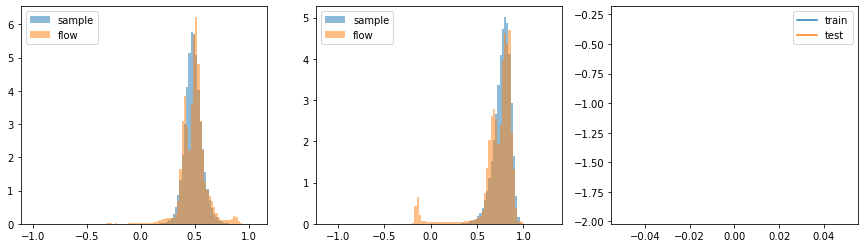

1
testing
2
testing
3
testing
4
testing
5
testing
6
testing
7
testing
8
testing
9
testing
10
testing
plotting


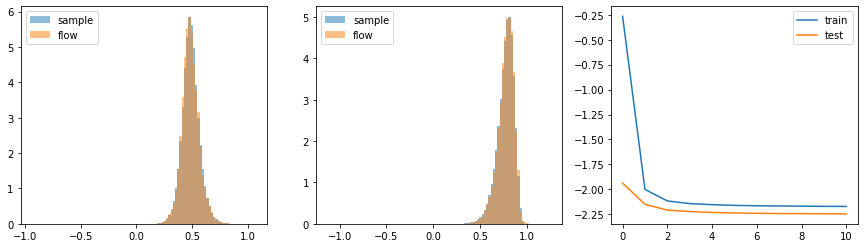

11
testing
12
testing
13
testing
14
testing
15
testing


In [23]:
flow_mc = make_base_flow_and_train(mc_loader_train, mc_loader_test, df_test)

0
testing
plotting


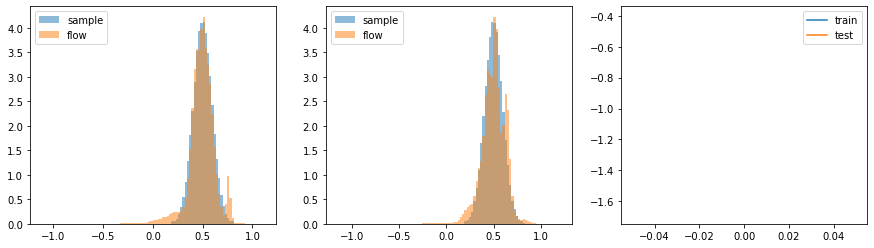

1
testing
2
testing
3
testing
4
testing
5
testing
6
testing
7
testing
8
testing
9
testing
10
testing
plotting


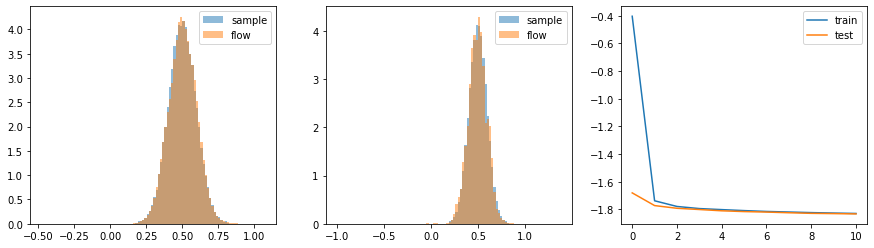

11
testing
12
testing
13
testing
14
testing
15
testing


In [24]:
flow_data = make_base_flow_and_train(data_loader_train, data_loader_test, df_target_test)

In [25]:
class BasePenalty(nn.Module):
    def __init__(self, weight=0.0):
        super(BasePenalty, self).__init__()
        self.register_buffer('weight', torch.Tensor([weight]))

    def penalty_function(self, inputs, outputs):
        return 0

    def forward(self, inputs, outputs):
        """Return calculation of distance penalty with gradients"""
        return self.weight * self.penalty_function(inputs, outputs)

class WrapPytorchPenalty(BasePenalty):
    """Wrapper class for distance penalty from any predefined pytorch method for FlowForFlow model"""
    def __init__(self, pytorch_method, weight):
        """Create a distance penalty class from a pytorch method
        Inputs
            pytorch_method: PyTorch function for distance penalty
            weight: relative weight for penalty term in total loss"""
        super(WrapPytorchPenalty, self).__init__(weight)
        self.torch_penalty = pytorch_method(reduction='none')

    def penalty_function(self, inputs, outputs):
        return self.torch_penalty(outputs, inputs).sum(-1)

class LOnePenalty(WrapPytorchPenalty):
    """L1 distance penalty clas for FlowForFlow models"""
    def __init__(self, weight):
        """Create a L1 distance penalty term
        Inputs
            weight: relative weight for penalty term in total loss"""
        super(LOnePenalty, self).__init__(nn.L1Loss, weight)
        
class AnnealedPenalty(BasePenalty):
    """Annealing weight for distance penalty class"""
    def __init__(self, penalty, n_steps=None, min_weight=0):
        """Create an annealing distance penalty term
        Inputs
            penalty: Distance penalty class
            n_steps: How many steps in the training of the flow
            min_weight minimum value for weight of distance penalty class"""
        super(AnnealedPenalty, self).__init__()
        self.min_weight = min_weight
        self.penalty_to_wrap = penalty
        self.initial_weight = deepcopy(self.penalty_to_wrap.weight)
        self.n_steps = n_steps
        self.pi = torch.tensor(np.pi, dtype=torch.float32)
        self.step = 0

    def set_n_steps(self, n_steps):
        if self.n_steps is None:
            self.n_steps = n_steps

    def update_weight(self):
        # TODO currently following a cosine schedule, but this should be possible to set/configure.
        self.penalty_to_wrap.weight = self.min_weight + 0.5 * (self.initial_weight - self.min_weight) * (
                    1 + (self.pi * self.step / self.n_steps).cos())
        self.step += 1

    def penalty_function(self, inputs, outputs):
        self.update_weight()
        return self.penalty_to_wrap.penalty_function(inputs, outputs)    

def set_penalty(f4flow, penalty, weight, anneal=False):
    if penalty not in ["None", None]:
        if penalty == "l1":
            penalty_constr = LOnePenalty
        penalty = penalty_constr(weight)
        if anneal:
            penalty = AnnealedPenalty(penalty)
        f4flow.add_penalty(penalty)

class FFFCustom(flows.Flow):
    def __init__(self, transform, flow_mc, flow_data, embedding_net=None):
        super().__init__(transform, flow_mc, embedding_net)
        self.flow_mc = flow_mc
        self.flow_data = flow_data

    def add_penalty(self, penalty_object):
        """Add a distance penaly object to the class."""
        assert isinstance(penalty_object, BasePenalty)
        self.distance_object = penalty_object

    def base_flow_log_prob(
        self, inputs, context, inverse=False
    ):
        if inverse:
            fnc = self.flow_mc.log_prob
        else:
            fnc = self.flow_data.log_prob
        logprob = fnc(inputs, context)
        return logprob

    def transform(self, inputs, context, inverse=False):
        context = self._embedding_net(context)
        transform = self._transform.inverse if inverse else self._transform
        y, logabsdet = transform(inputs, context)

        return y, logabsdet

    def log_prob(self, inputs, context, inverse=False):
        converted_input, logabsdet = self.transform(
            inputs, context, inverse=inverse
        )
        log_prob = self.base_flow_log_prob(
            converted_input, context, inverse=inverse
        )
        dist_pen = -self.distance_object(converted_input, inputs)

        return log_prob, logabsdet, dist_pen

In [26]:
# freeze base flows
for param in flow_data.parameters():
    param.requires_grad = False

for param in flow_mc.parameters():
    param.requires_grad = False

fffmodel = FFFCustom(
    spline_inn(
        ninput,
        nodes=2,
        num_blocks=2,
        num_stack=4,
        tail_bound=1.0,
        activation=F.relu,
        dropout_probability=0.1,
        num_bins=16,
        context_features=ncontext,
        flow_for_flow=True,
    ),
    flow_mc,
    flow_data
)
set_penalty(
    fffmodel,
    "l1",
    0.1,
    False
)
fffmodel = fffmodel.to(device)

In [27]:
optimizer = torch.optim.Adam(
    fffmodel.parameters(),
    lr=0.001,
    #betas=(cfg.optimizer.beta1, cfg.optimizer.beta2),
    #weight_decay=cfg.optimizer.weight_decay,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

0


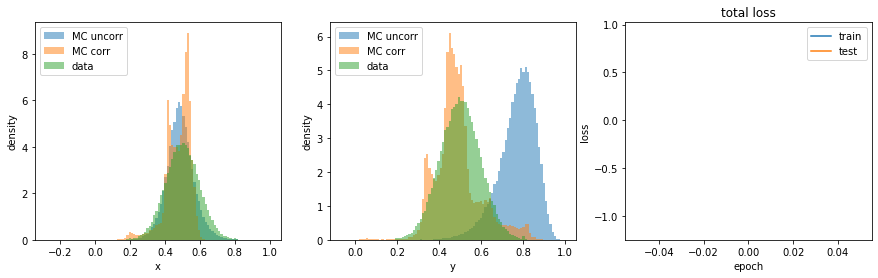

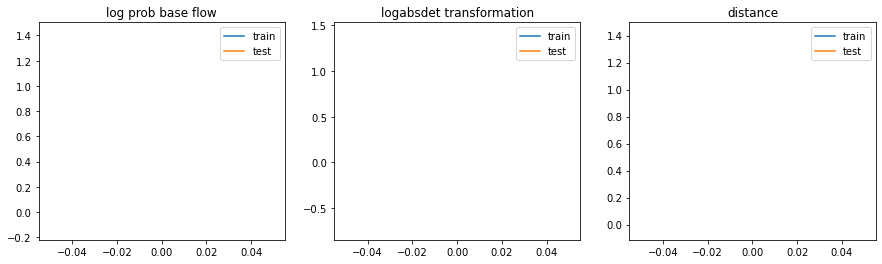

1
2
3
4


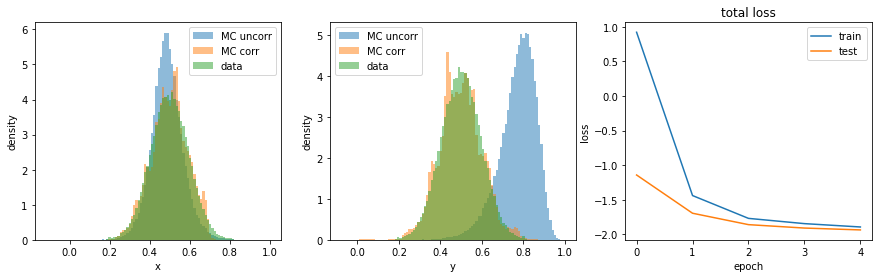

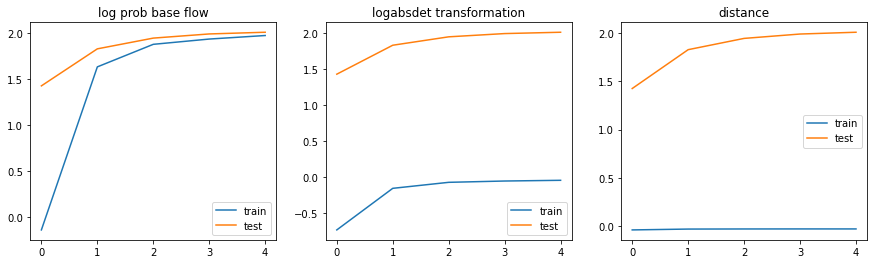

5
6
7
8


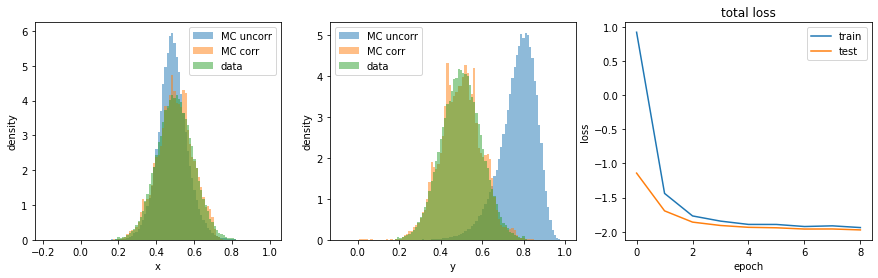

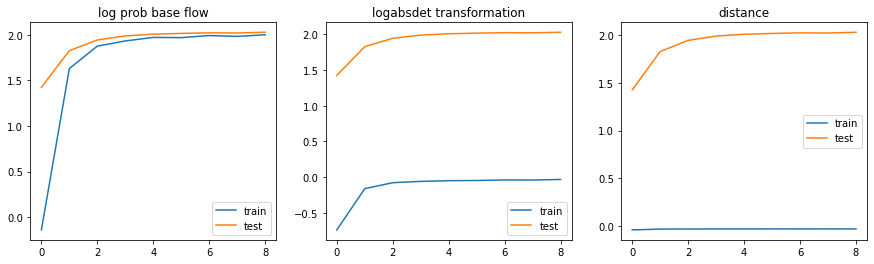

9
10
11
12


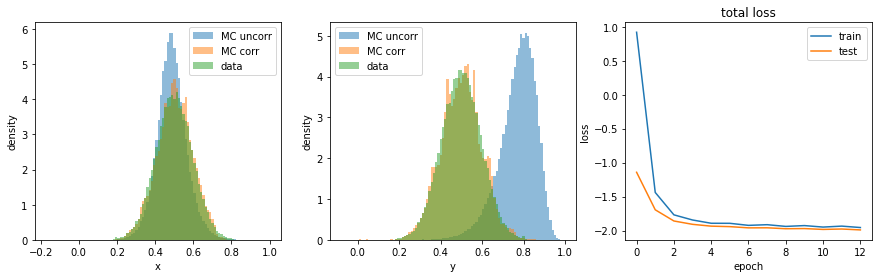

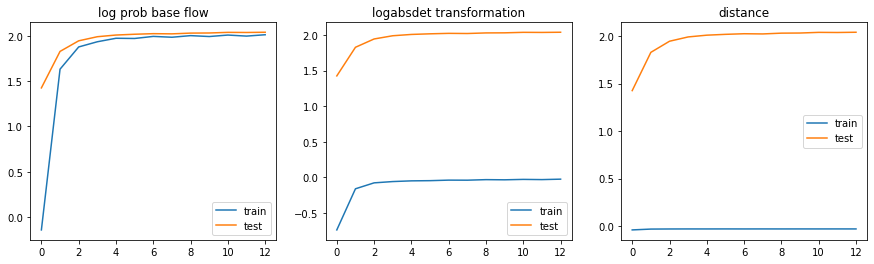

13
14
15
16


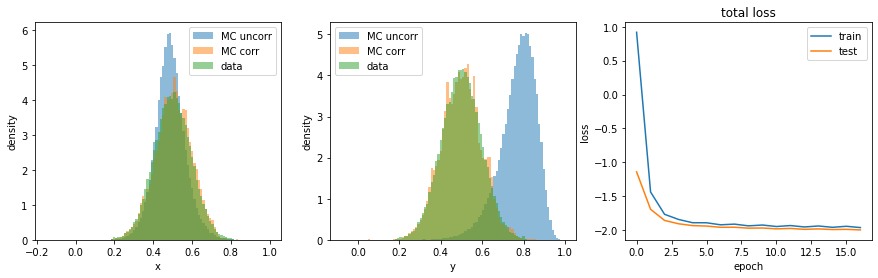

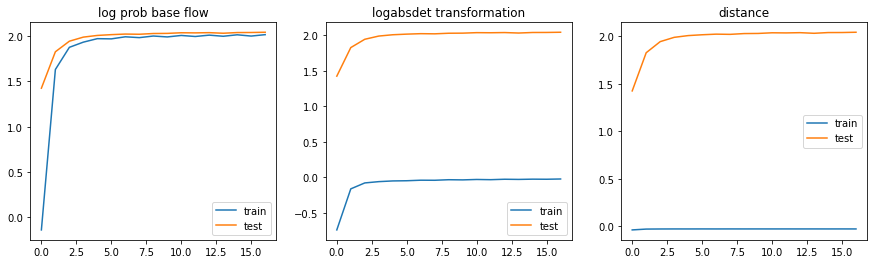

17
18
19
20


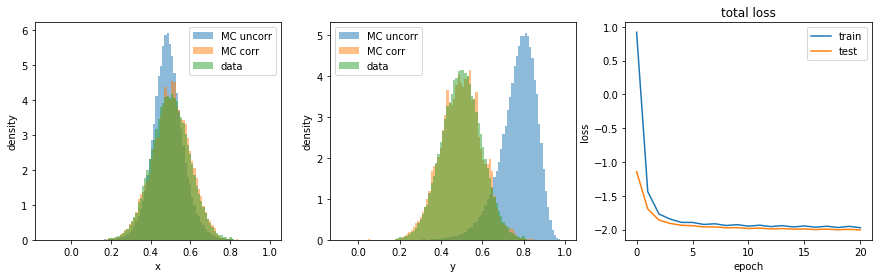

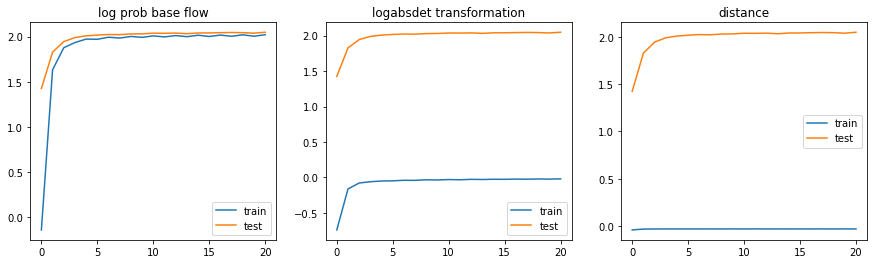

21
22
23
24


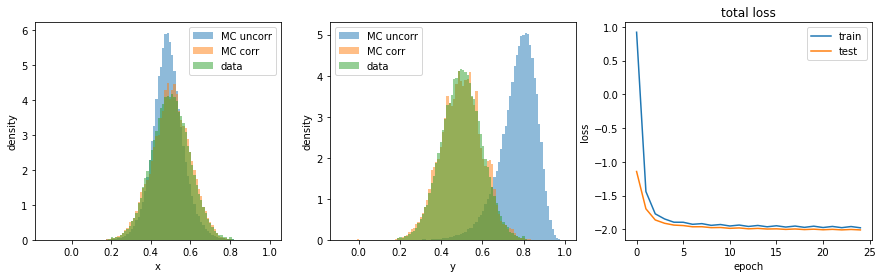

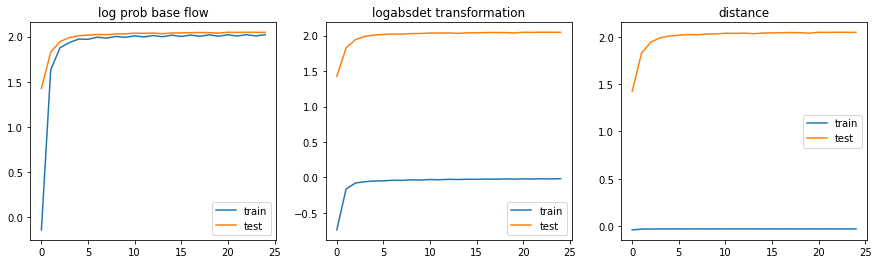

25
26
27
28


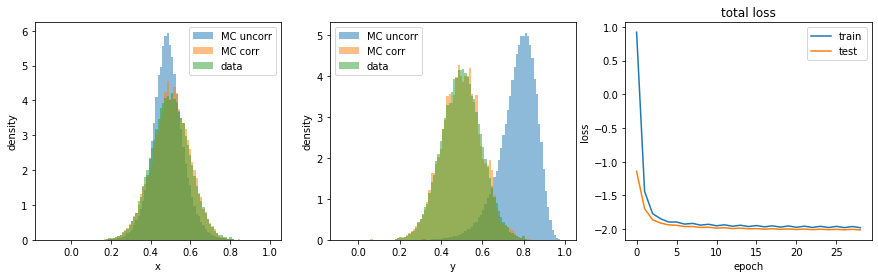

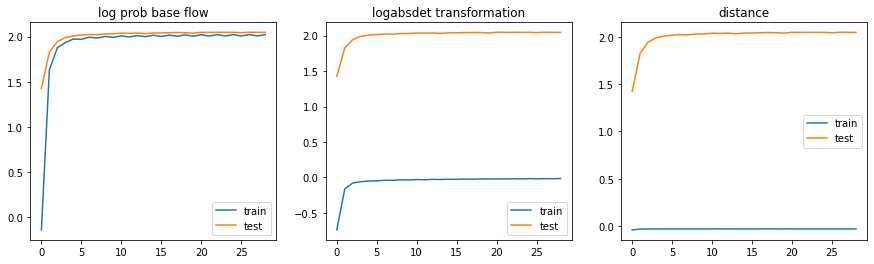

29
30
31
32


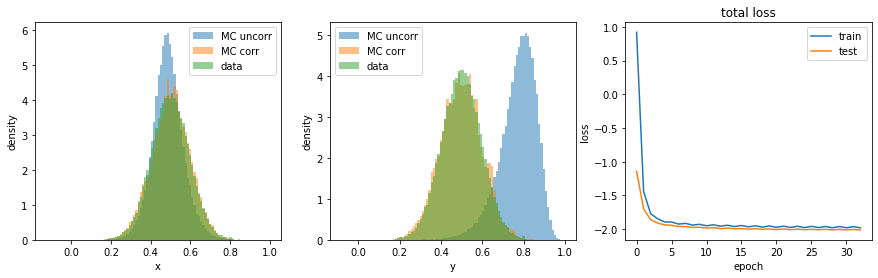

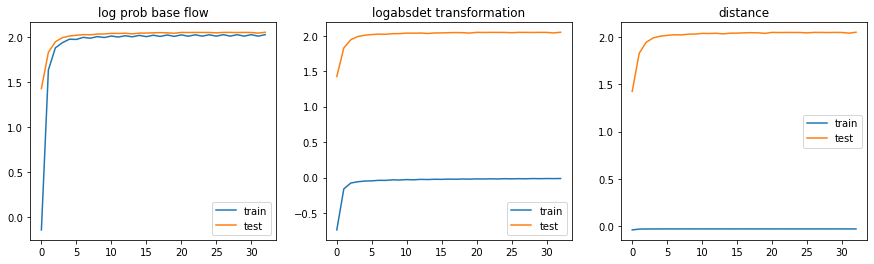

33
34
35
36


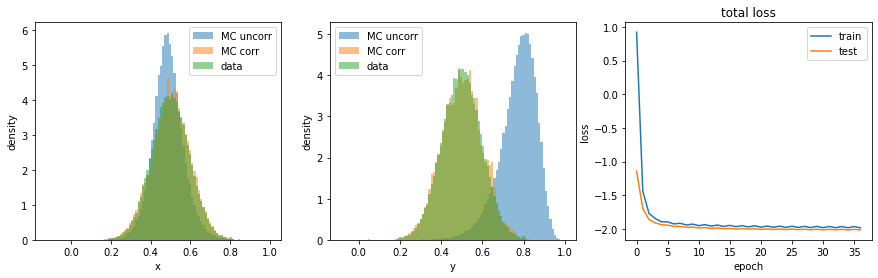

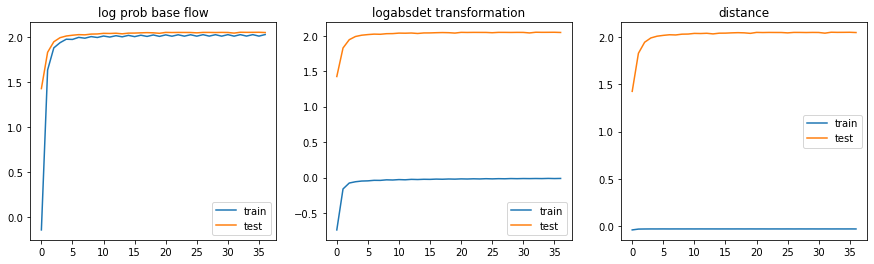

37
38
39
40


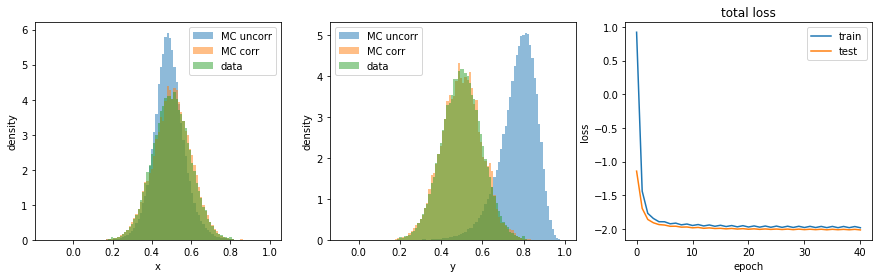

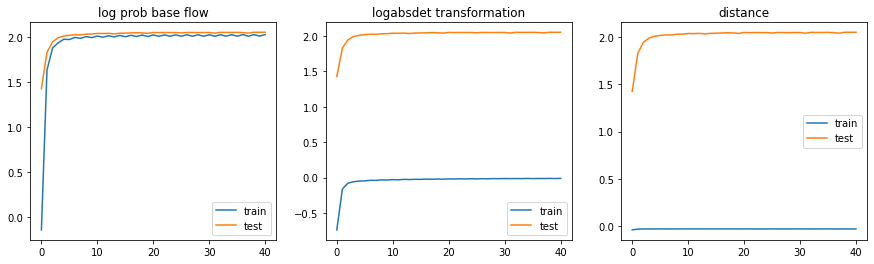

41
42
43
44


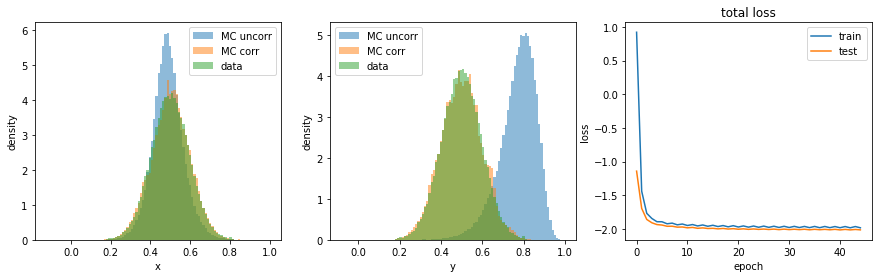

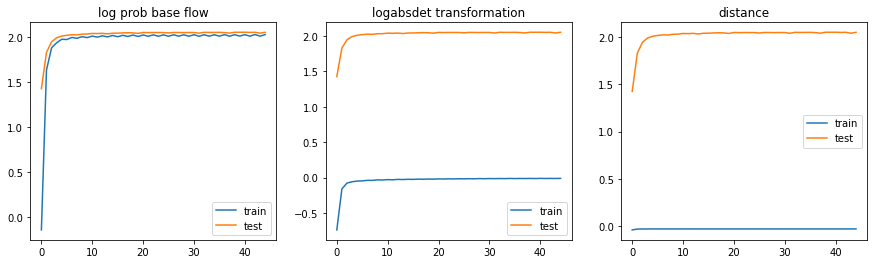

45
46
47
48


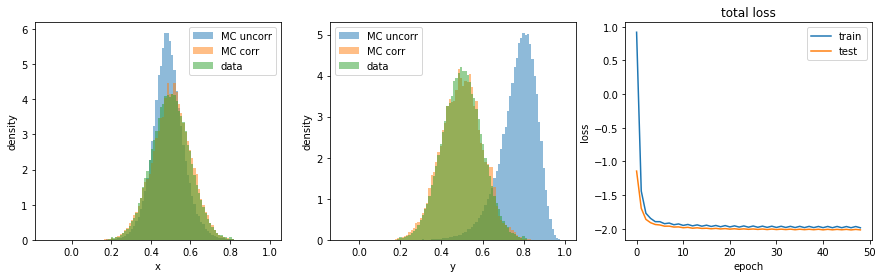

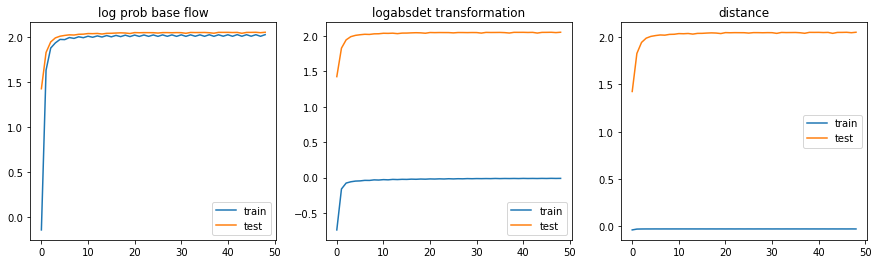

49
50
51
52


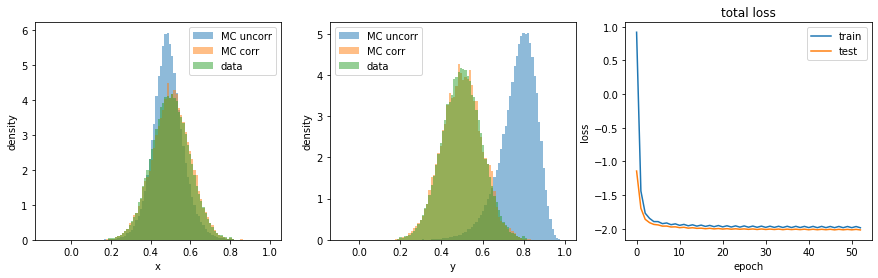

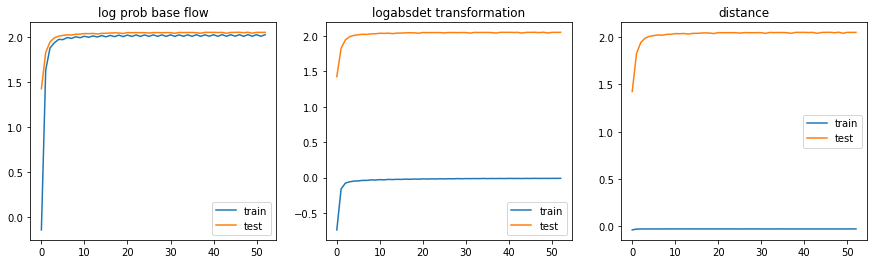

53
54
55
56


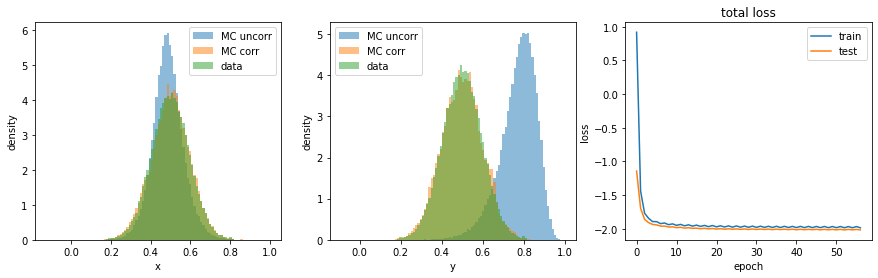

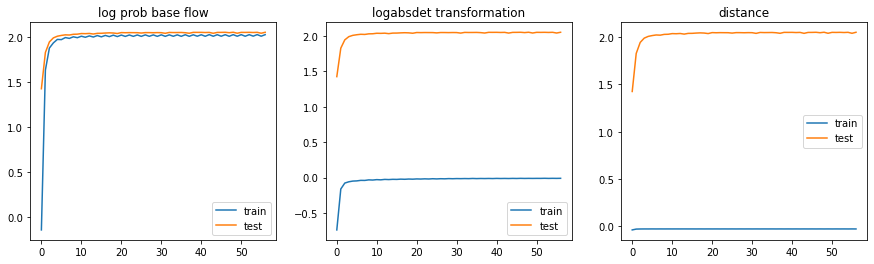

57
58
59
60


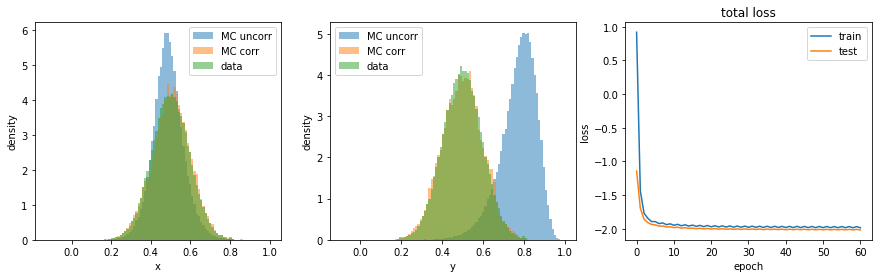

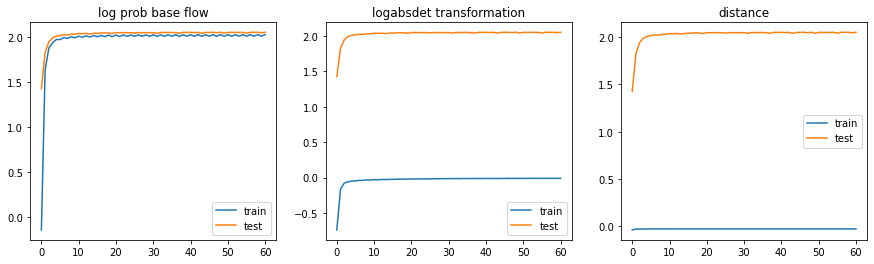

61
62
63
64


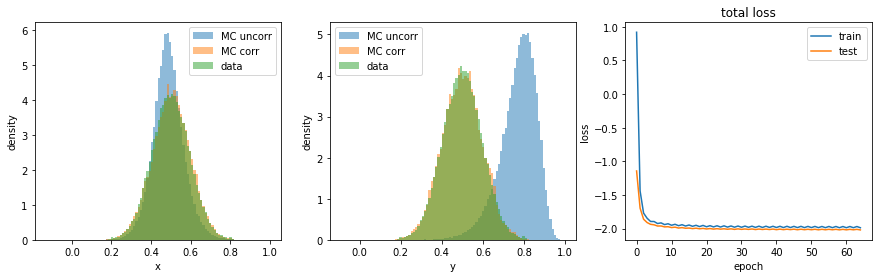

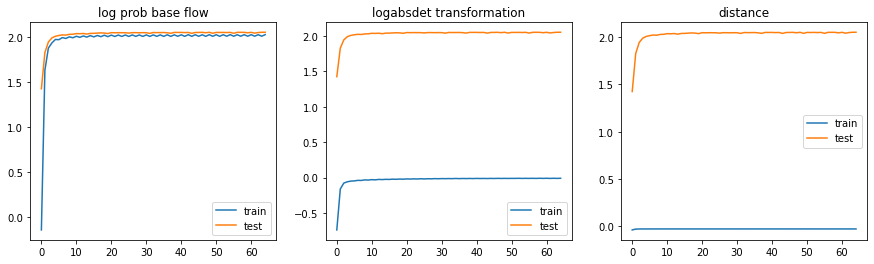

65
66
67
68


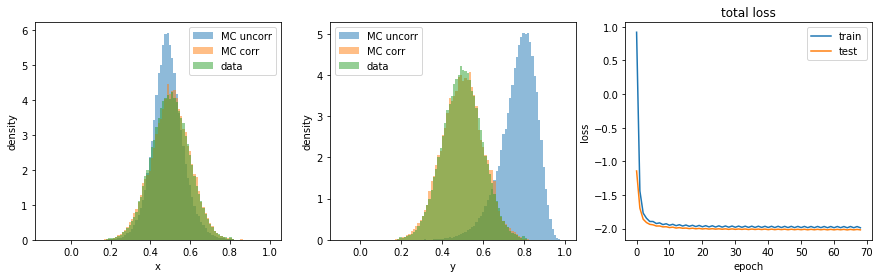

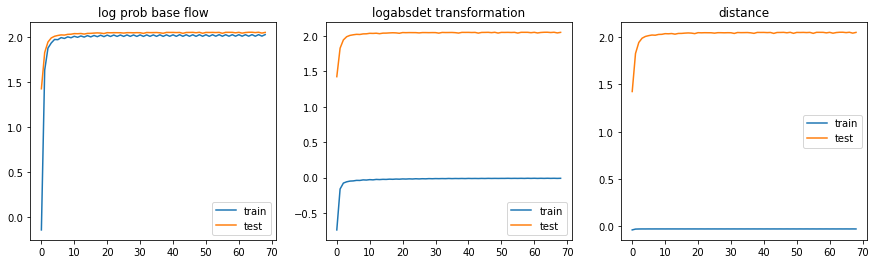

69
70
71
72


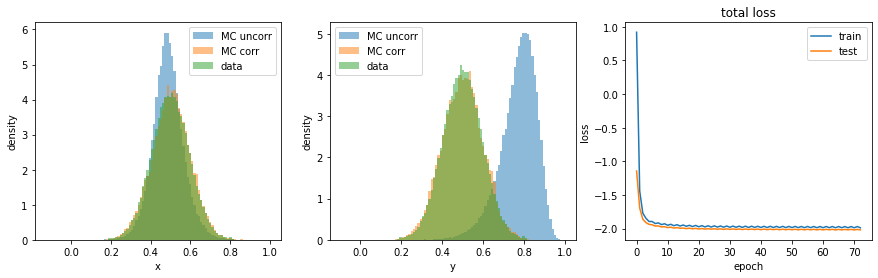

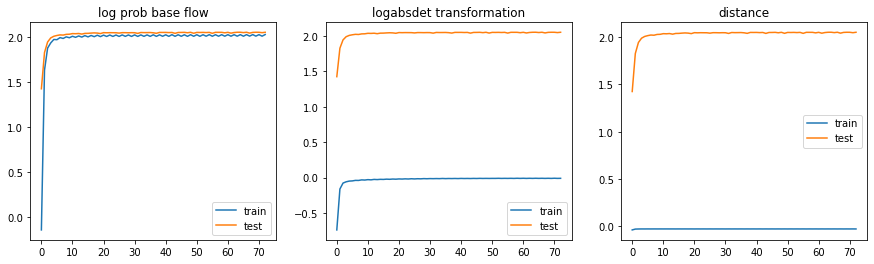

73
74
75
76


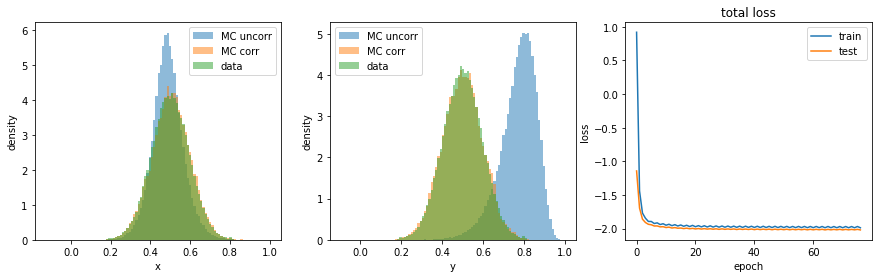

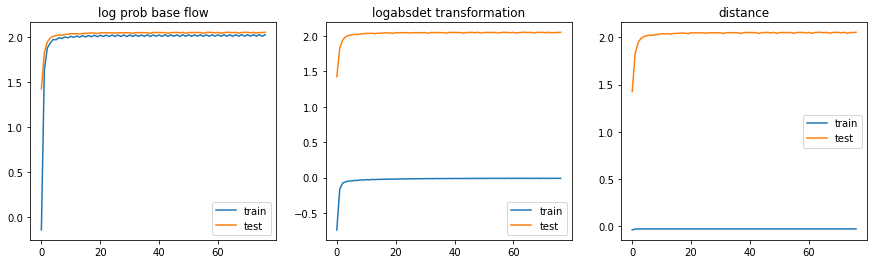

77
78
79
80


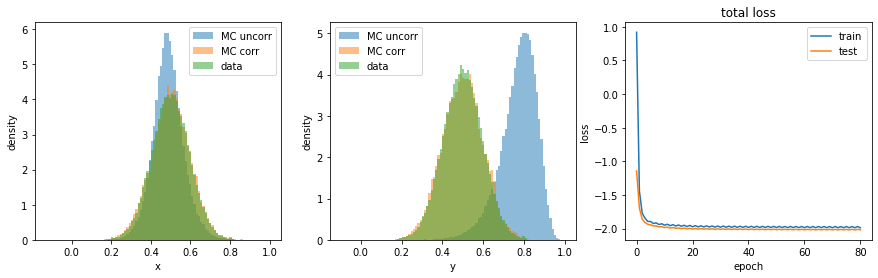

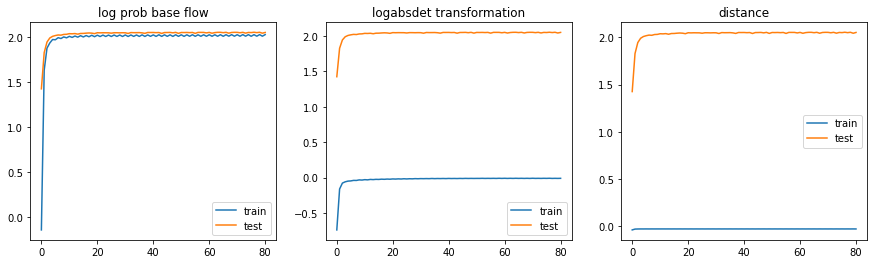

81
82
83
84


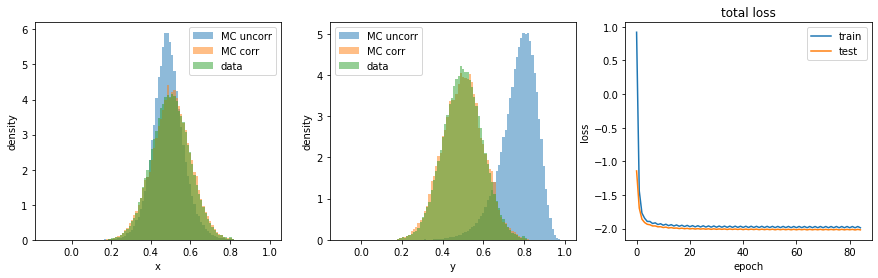

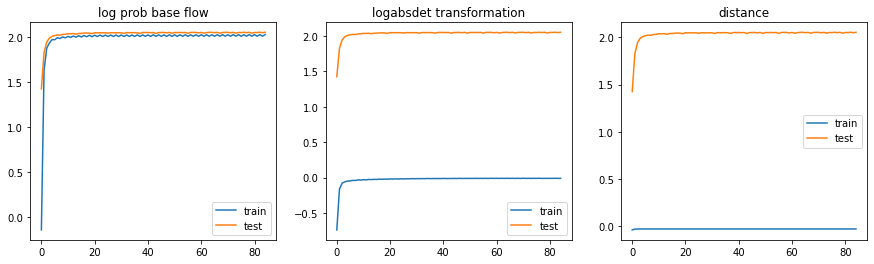

85
86
87
88


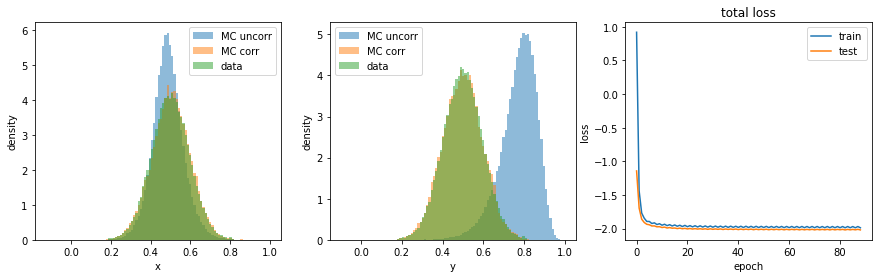

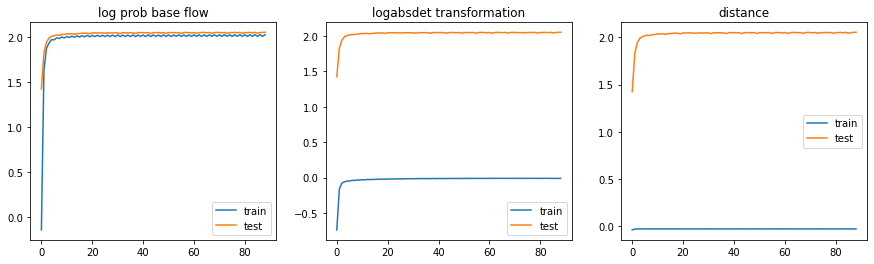

89
90
91
92


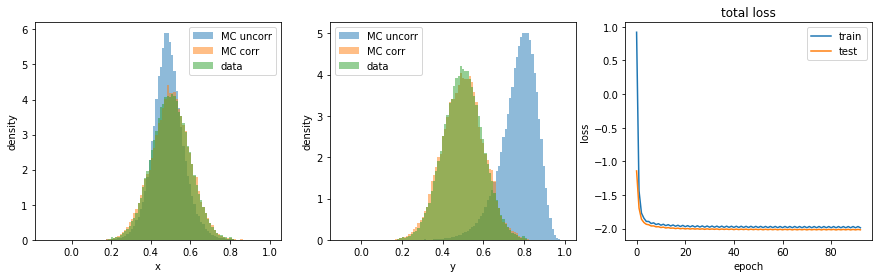

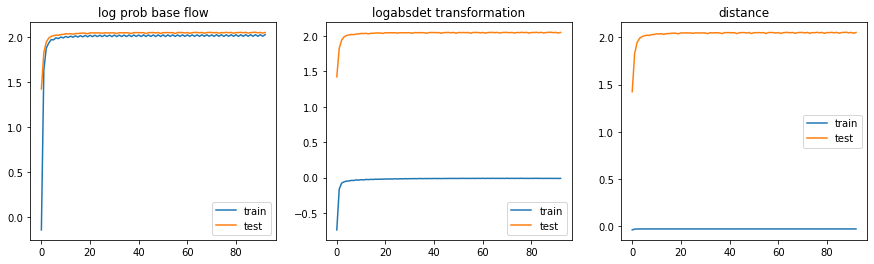

93
94
95
96


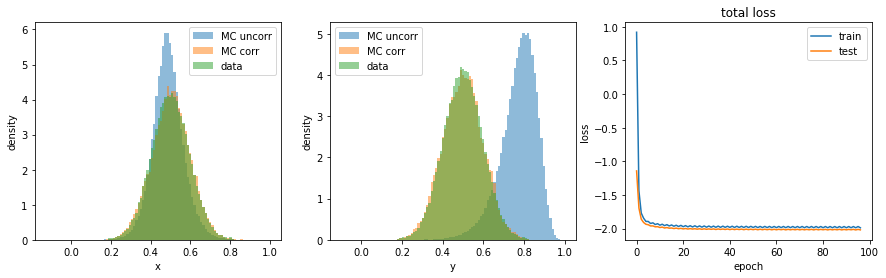

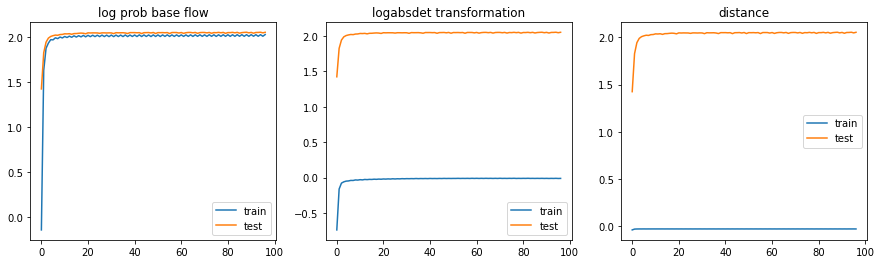

97
98
99
100


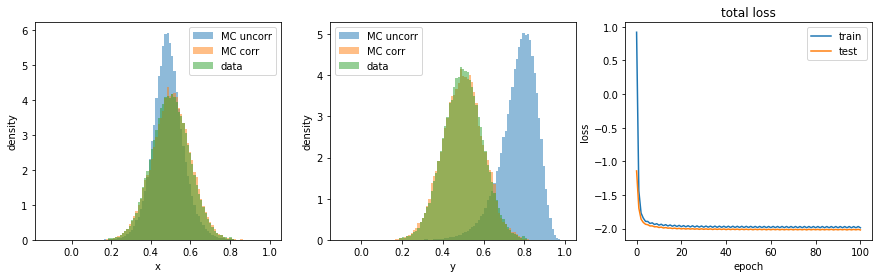

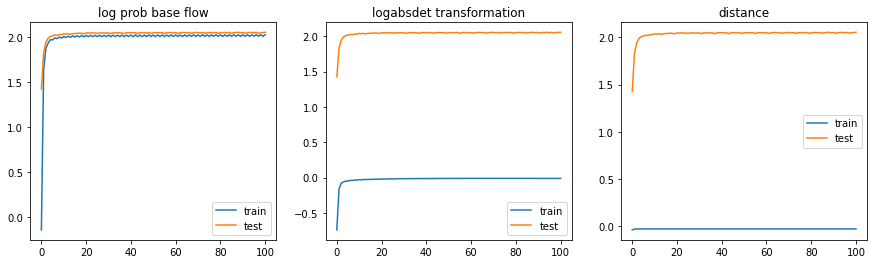

101
102
103
104


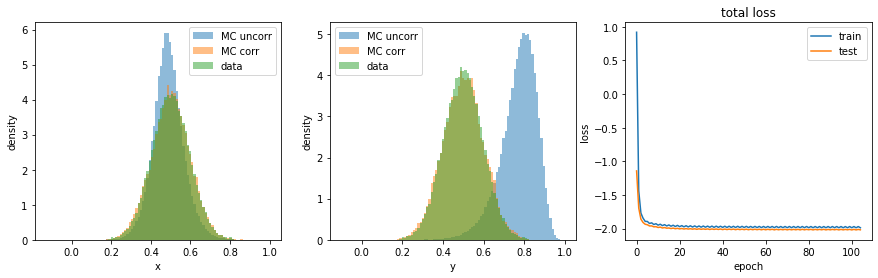

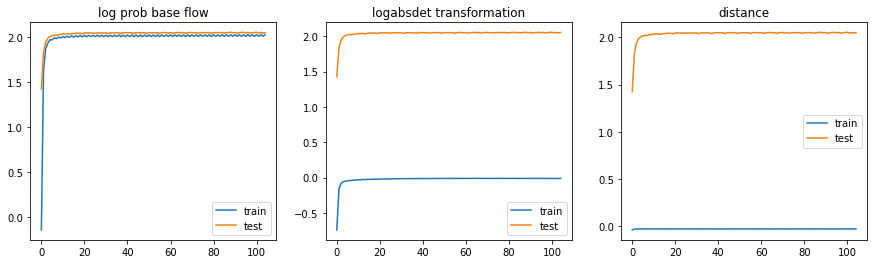

105
106
107
108


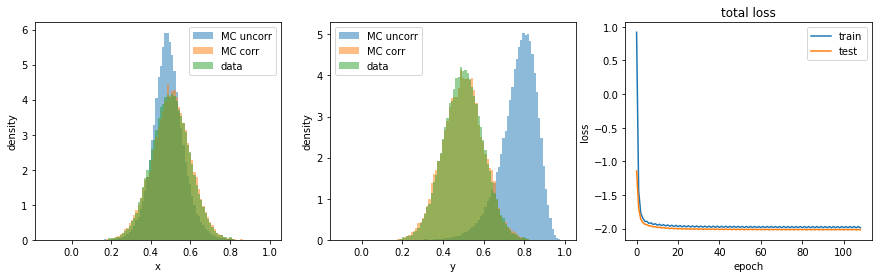

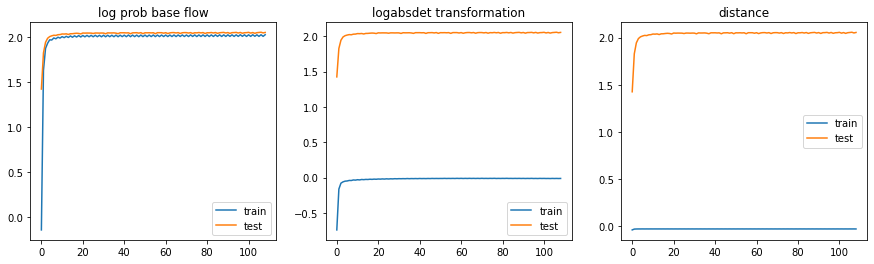

109
110
111
112


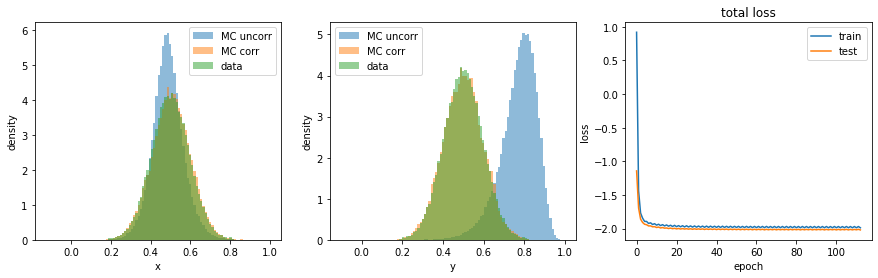

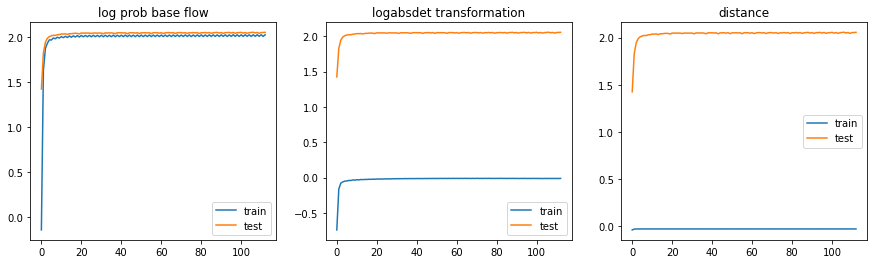

113
114
115
116


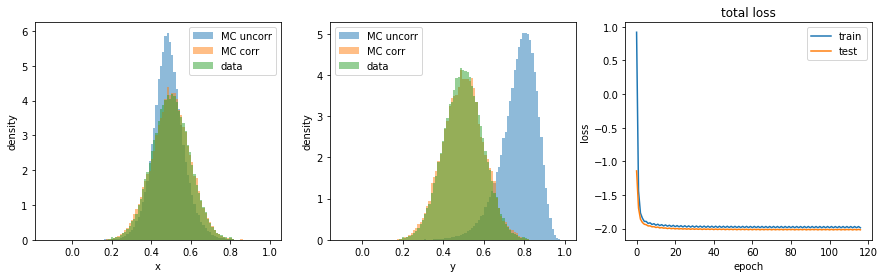

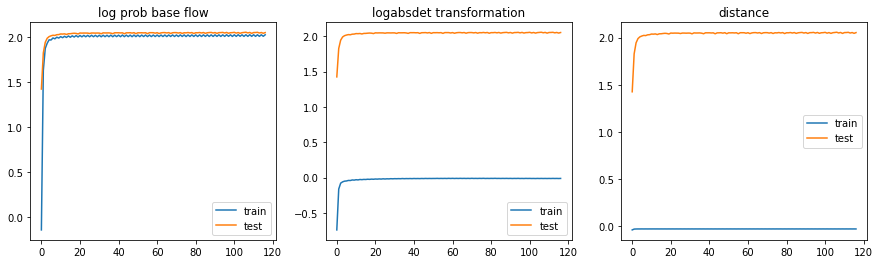

117
118
119
120


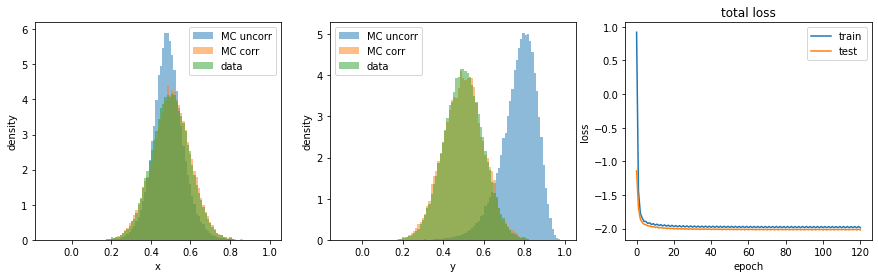

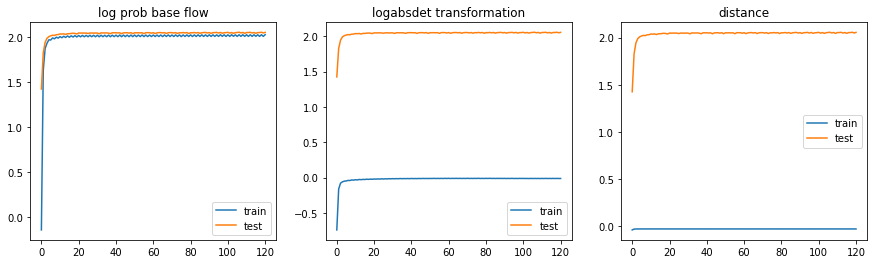

121
122
123
124


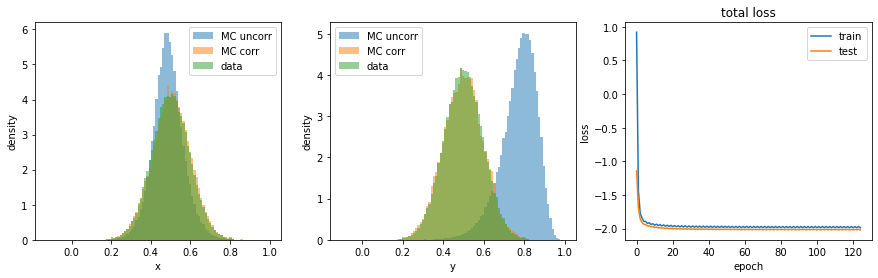

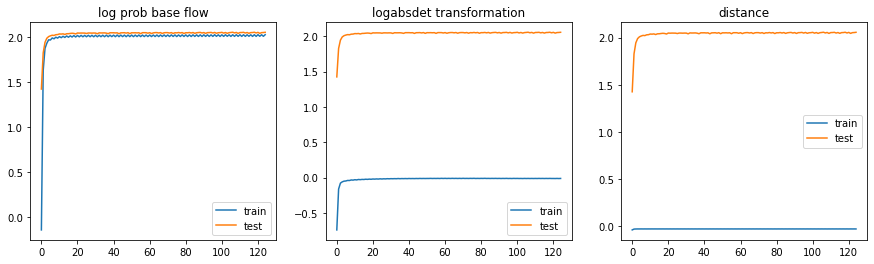

125
126
127
128


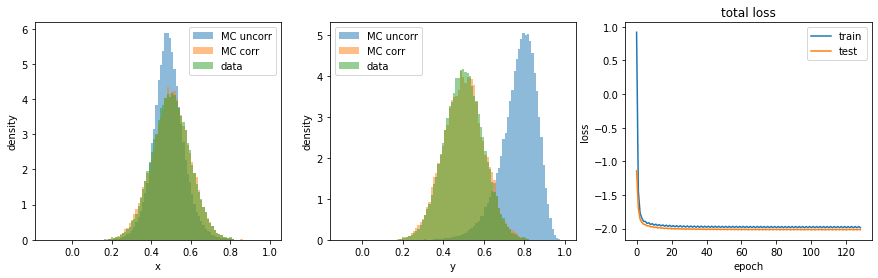

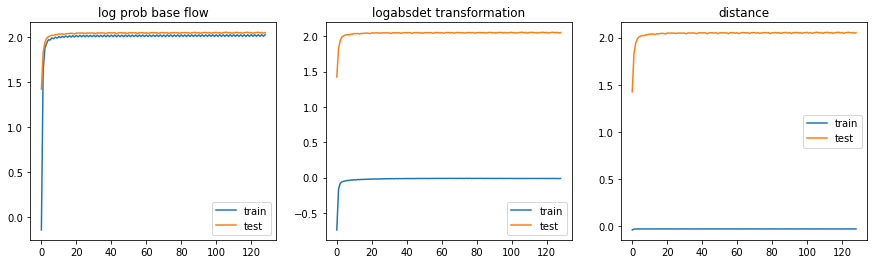

129
130
131
132


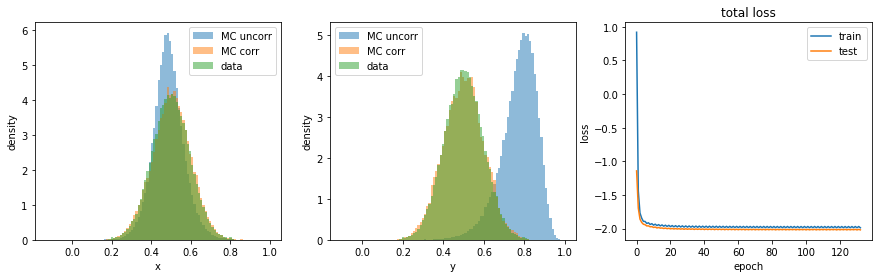

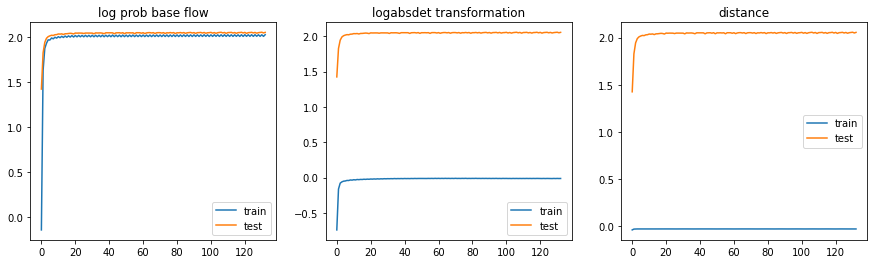

133
134
135
136


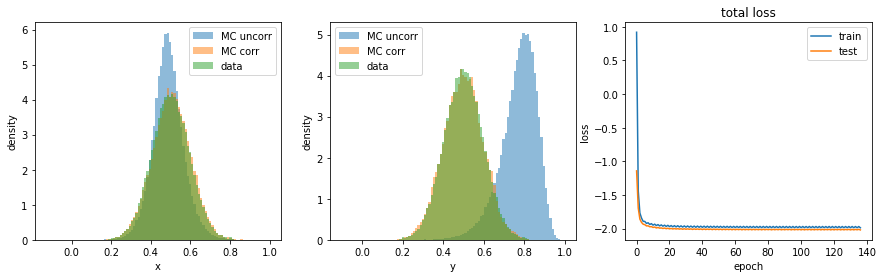

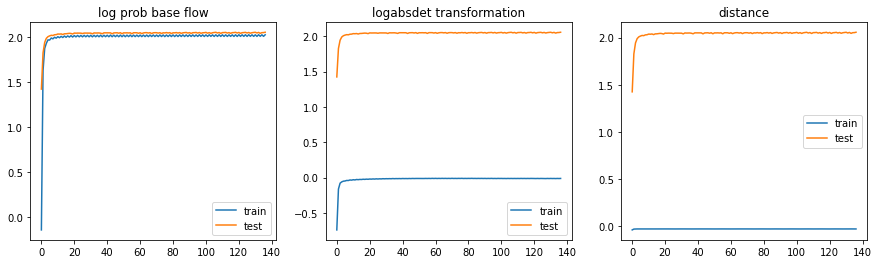

137
138
139
140


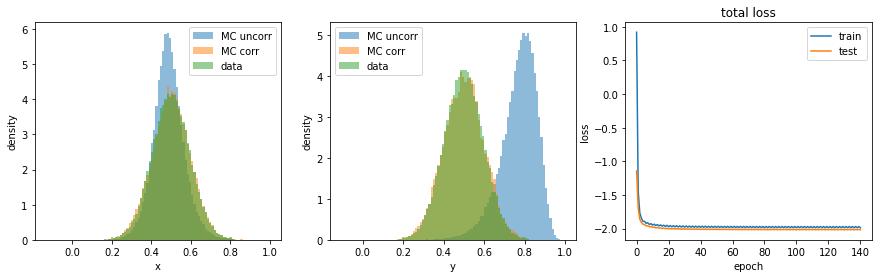

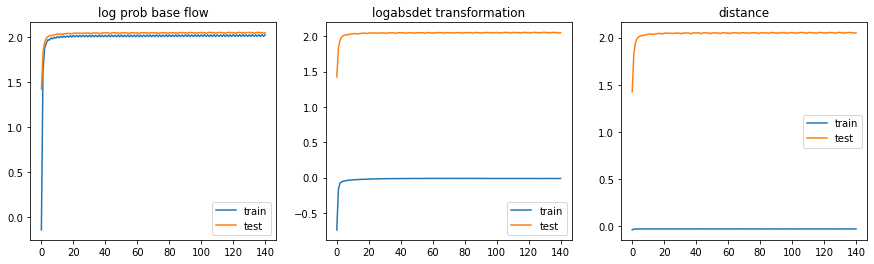

141
142
143
144


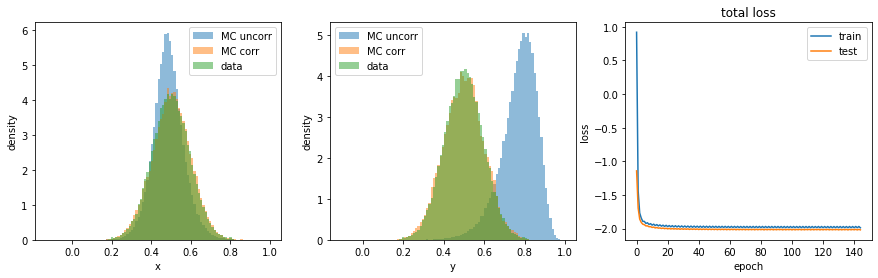

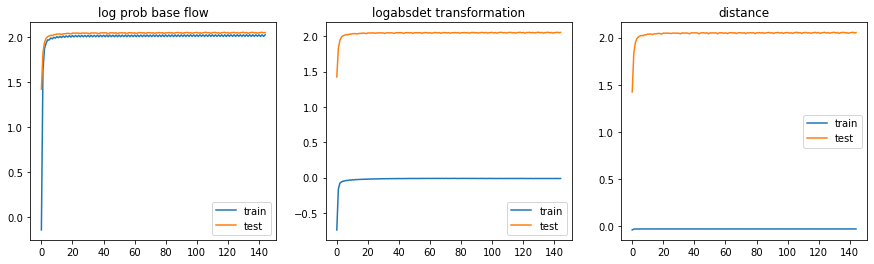

145
146
147
148


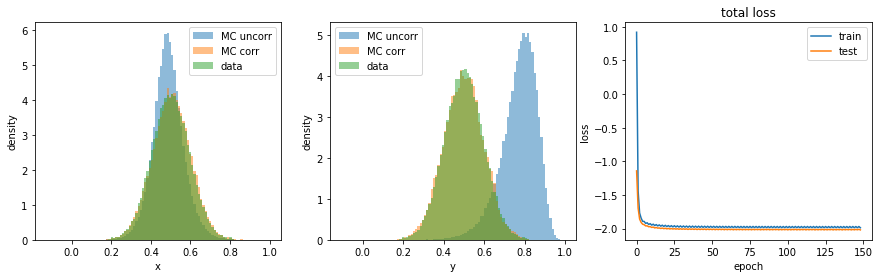

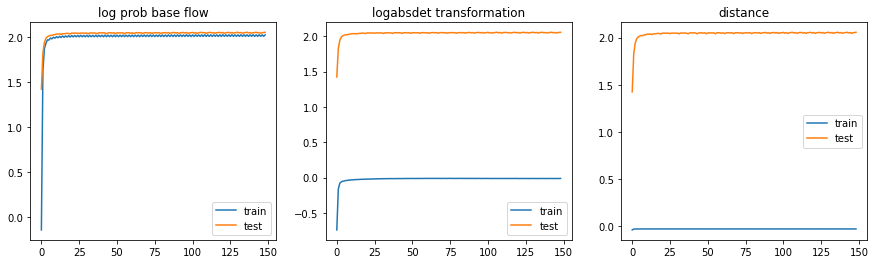

149
150
151
152


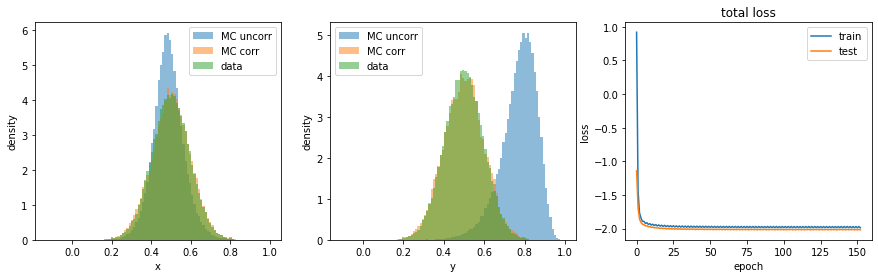

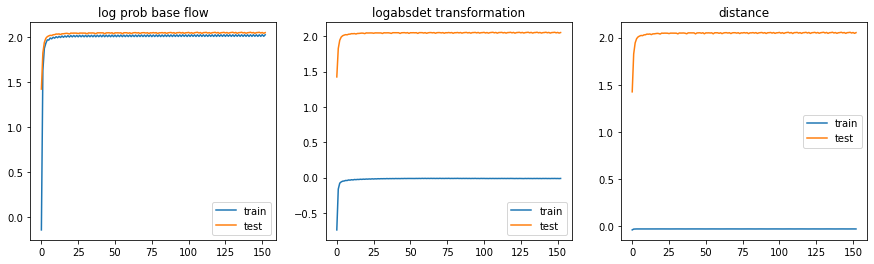

153
154
155
156


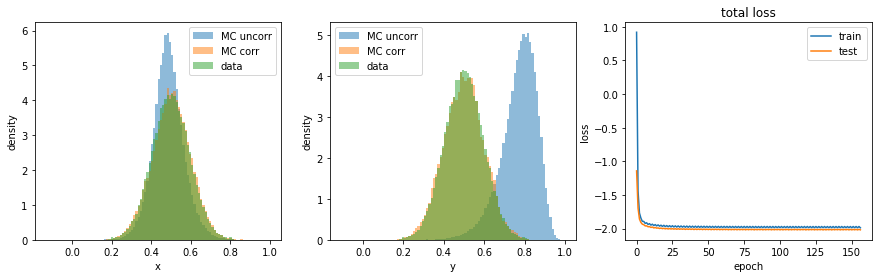

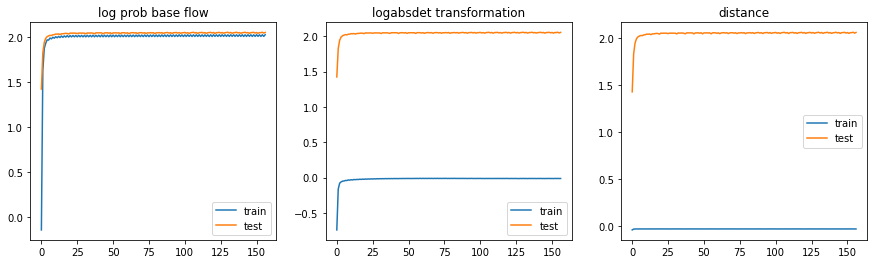

157
158
159
160


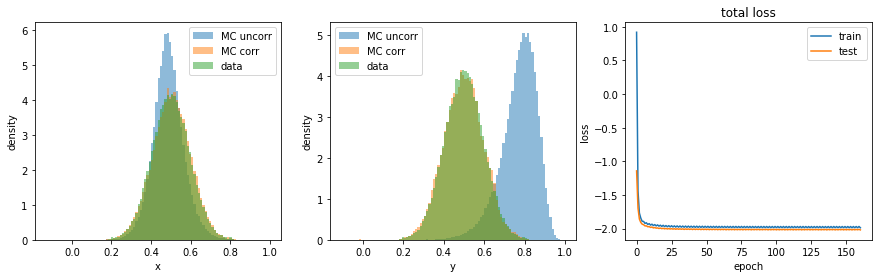

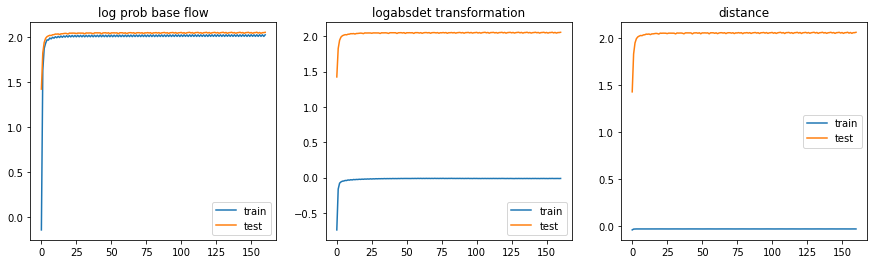

161
162
163
164


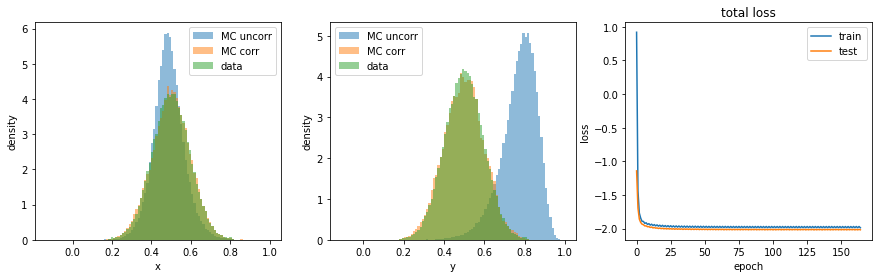

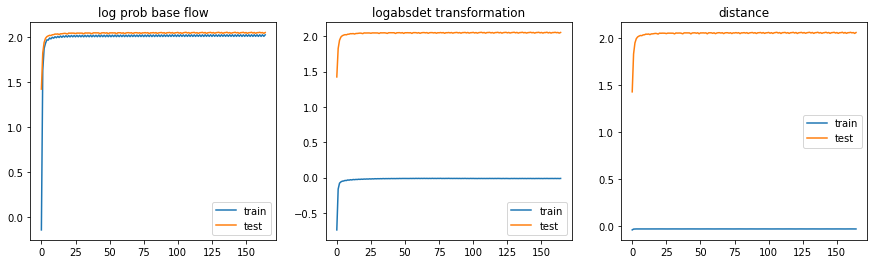

165
166
167
168


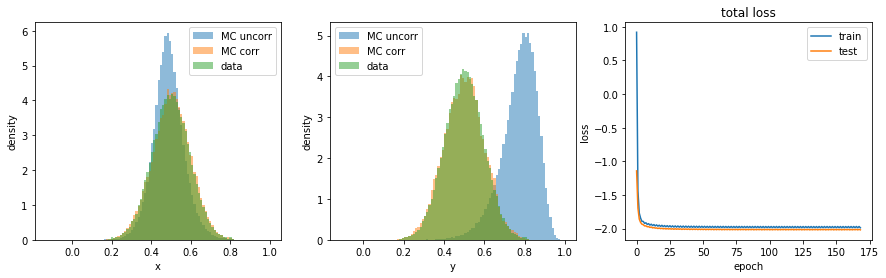

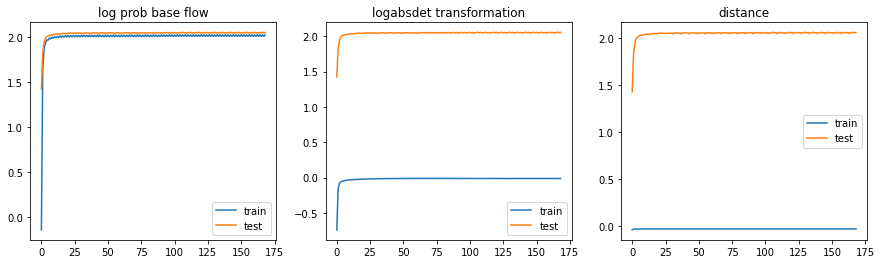

169
170
171
172


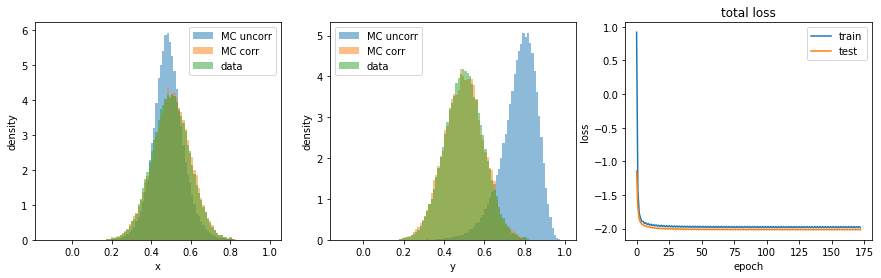

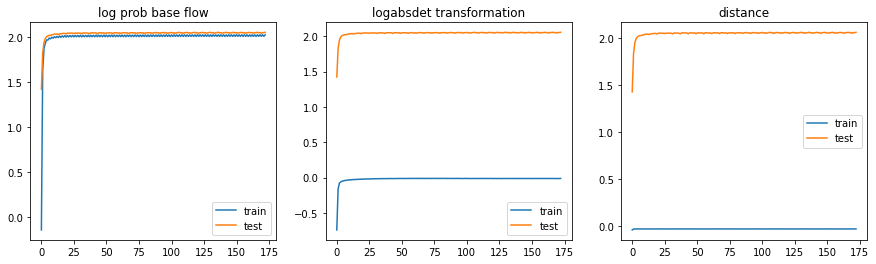

173
174
175
176


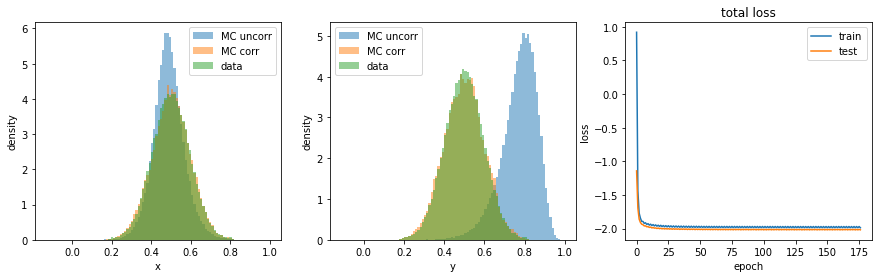

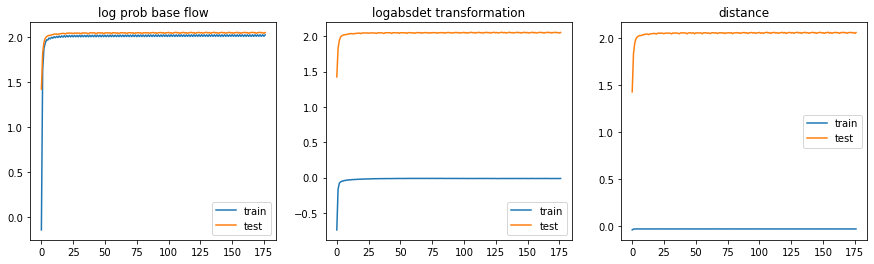

177
178
179
180


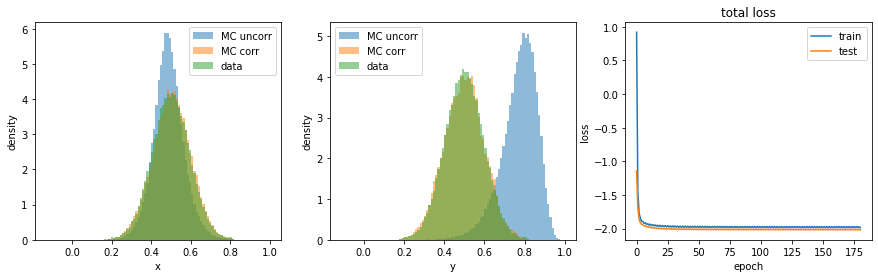

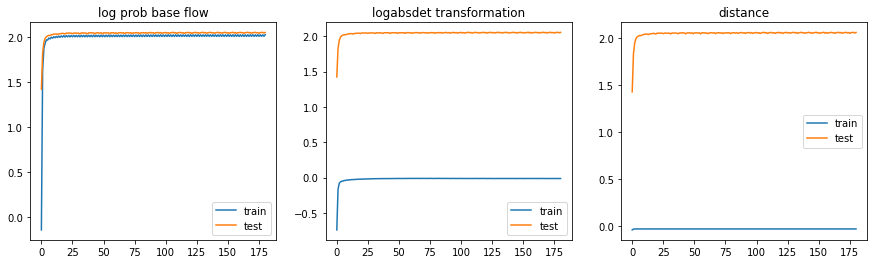

181
182
183
184


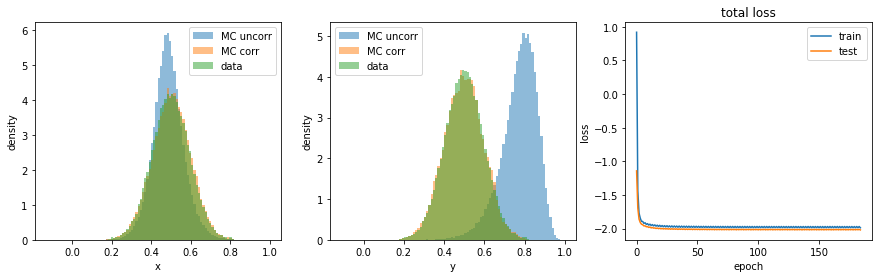

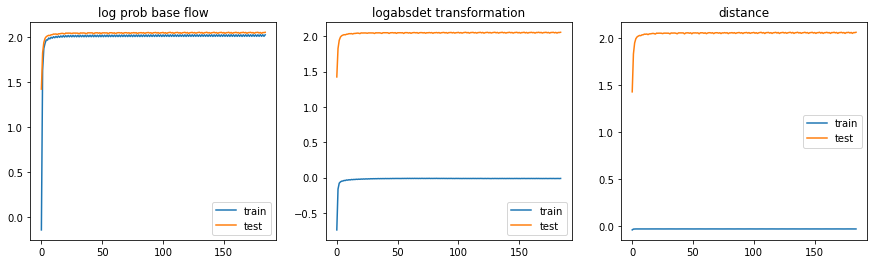

185
186
187
188


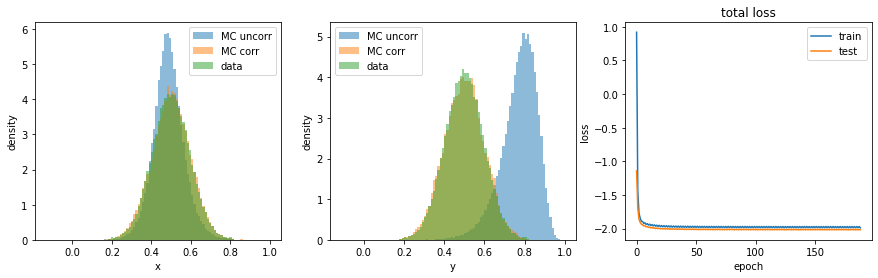

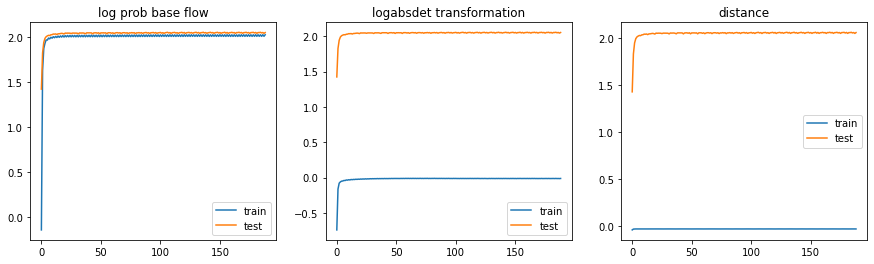

189
190
191
192


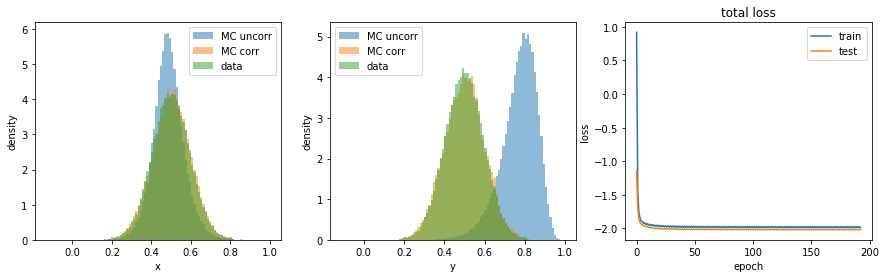

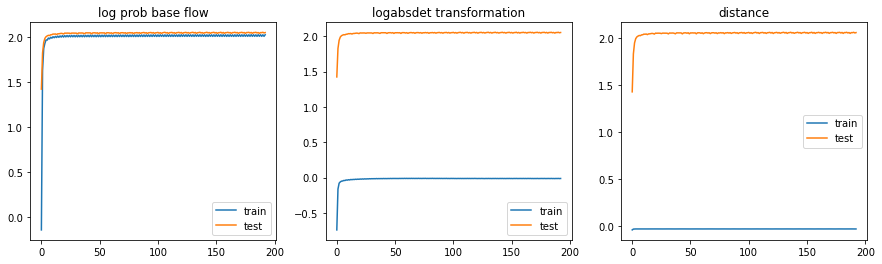

193
194
195
196


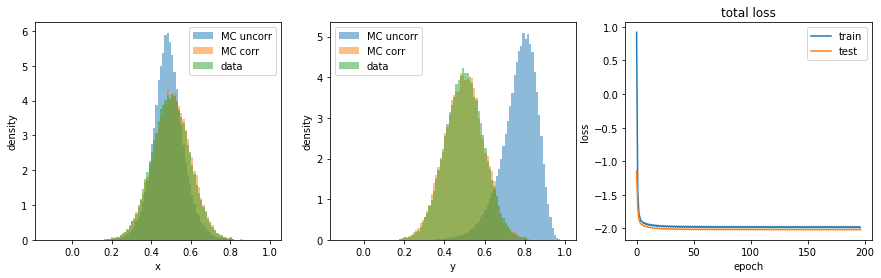

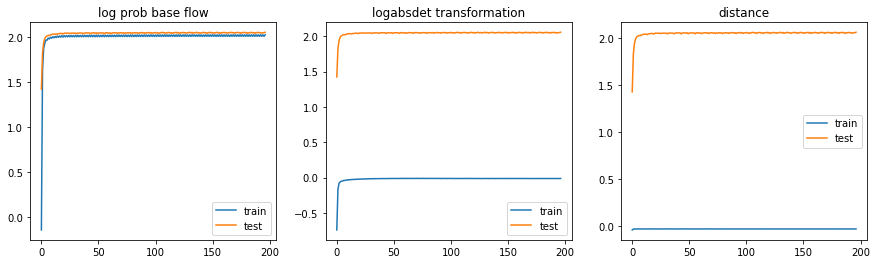

197
198
199


In [28]:
epochs = 200
batch_size = 512
plot_every = 4

train_history, test_history = [], []
train_history1, test_history1 = [], []
train_history2, test_history2 = [], []
train_history3, test_history3 = [], []
for epoch in range(epochs):
    print(epoch)
    epoch_is_even = epoch % 2 == 0
    train_losses, test_losses = [], []
    train_losses1, test_losses1 = [], []
    train_losses2, test_losses2 = [], []
    train_losses3, test_losses3 = [], []
    # train
    for i, (data, mc) in enumerate(zip(data_loader_train, mc_loader_train)):
        if i % 2 == 0 + int(epoch_is_even):
            inverse = False
            ab, xy, weights = mc
        else:
            inverse = True
            ab, xy, weights = data
        optimizer.zero_grad()
        loss1, loss2, loss3 = fffmodel.log_prob(xy, ab, inverse=inverse)
        loss1 = loss1 * weights
        loss2 = loss2 * weights
        loss3 = loss3 * weights
        loss = - (loss1 + loss2 + loss3)
        loss = loss.mean()
        loss1 = loss1.mean()
        loss2 = loss2.mean()
        loss3 = loss3.mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
        train_losses1.append(loss1.item())
        train_losses2.append(loss2.item())
        train_losses3.append(loss3.item())
    train_history.append(np.mean(train_losses))
    train_history1.append(np.mean(train_losses1))
    train_history2.append(np.mean(train_losses2))
    train_history3.append(np.mean(train_losses3))
    
    # test
    for i, (data, mc) in enumerate(zip(data_loader_test, mc_loader_test)):
        if i % 2 == 0 + int(epoch_is_even):
            inverse = False
            ab, xy, weights = mc
        else:
            inverse = True
            ab, xy, weights = data
        with torch.no_grad():
            loss1, loss2, loss3 = fffmodel.log_prob(xy, ab, inverse=inverse)
            loss1 = loss1 * weights
            loss2 = loss2 * weights
            loss3 = loss3 * weights
            loss = - (loss1 + loss2 + loss3)
            loss = loss.mean()
            loss1 = loss1.mean()
            loss2 = loss2.mean()
            loss3 = loss3.mean()
            test_losses.append(loss.item())
            test_losses1.append(loss1.item())
            test_losses2.append(loss2.item())
            test_losses3.append(loss3.item())
    test_history.append(np.mean(test_losses))
    test_history1.append(np.mean(test_losses1))
    test_history2.append(np.mean(test_losses2))
    test_history3.append(np.mean(test_losses3))

    if epoch % plot_every == 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        ab = torch.tensor(df_test[['a', 'b']].values, dtype=torch.float32).to(device)
        xy_mc_uncorr = torch.tensor(df_test[['x', 'y']].values, dtype=torch.float32).to(device)
        xy_mc_corr = fffmodel.transform(xy_mc_uncorr, ab, inverse=False)
        x_mc_uncorr, y_mc_uncorr = xy_mc_uncorr[:, 0].detach().cpu().numpy(), xy_mc_uncorr[:, 1].detach().cpu().numpy()
        x_mc_corr, y_mc_corr = xy_mc_corr[0][:, 0].detach().cpu().numpy(), xy_mc_corr[0][:, 1].detach().cpu().numpy()
        x_data, y_data = df_target_test['x'].values, df_target_test['y'].values
        # plot
        x_min = min(x_mc_uncorr.min(), x_mc_corr.min(), x_data.min())
        x_max = max(x_mc_uncorr.max(), x_mc_corr.max(), x_data.max())
        ax1.hist(x_mc_uncorr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC uncorr', weights=df_test['weight'])
        ax1.hist(x_mc_corr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC corr', weights=df_test['weight'])
        ax1.hist(x_data, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='data')
        ax1.set_xlabel('x')
        ax1.set_ylabel('density')
        ax1.legend()
        y_min = min(y_mc_uncorr.min(), y_mc_corr.min(), y_data.min())
        y_max = max(y_mc_uncorr.max(), y_mc_corr.max(), y_data.max())
        ax2.hist(y_mc_uncorr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC uncorr', weights=df_test['weight'])
        ax2.hist(y_mc_corr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC corr', weights=df_test['weight'])
        ax2.hist(y_data, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='data')
        ax2.set_xlabel('y')
        ax2.set_ylabel('density')
        ax2.legend()
        ax3.plot(train_history, label='train')
        ax3.plot(test_history, label='test')
        ax3.set_xlabel('epoch')
        ax3.set_ylabel('loss')
        ax3.set_title('total loss')
        ax3.legend()
        plt.show()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        ax1.plot(train_history1, label='train')
        ax1.plot(test_history1, label='test')
        ax1.set_title('log prob base flow')
        ax1.legend()
        ax2.plot(train_history2, label='train')
        ax2.plot(test_history1, label='test')
        ax2.set_title('logabsdet transformation')
        ax2.legend()
        ax3.plot(train_history3, label='train')
        ax3.plot(test_history1, label='test')
        ax3.set_title('distance')
        ax3.legend()
        plt.show()
